In [19]:
#imports:
# !pip install
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from datagenerator import dataset_size
from datagenerator import data_generator
from datagenerator import *

In [20]:
# constants:
RESIZED_WIDTH = 100  # temp
RESIZED_HEIGHT = 100  # temp
RESIZED_NUM_PIXELS = RESIZED_WIDTH * RESIZED_HEIGHT
SHAPE = RESIZED_NUM_PIXELS + 3
TRAIN_PATH = r'C:\Users\hadar\Desktop\Advanced_Lab\run_1_data\train_valid_test\train'  # temp
VALID_PATH = r'C:\Users\hadar\Desktop\Advanced_Lab\run_1_data\train_valid_test\valid'  # temp
TEST_PATH = r'C:\Users\hadar\Desktop\Advanced_Lab\run_1_data\train_valid_test\test'  # temp
BACH_SIZE = 8  # temp
TRAIN_DATASET_SIZE = dataset_size(TRAIN_PATH)
VALID_DATASET_SIZE = dataset_size(VALID_PATH)
TEST_DATA_SIZE = dataset_size(TEST_PATH)
STEPS_PER_EPOCH = TRAIN_DATASET_SIZE // BACH_SIZE
EPOCHS = 8  # temp
VALIDATION_STEPS = VALID_DATASET_SIZE // BACH_SIZE
TEST_STEPS = TEST_DATA_SIZE // BACH_SIZE

In [21]:
# activating data gen:
train_generator = data_generator(TRAIN_PATH, BACH_SIZE,
                                 True, RESIZED_WIDTH, RESIZED_HEIGHT)
validation_generator = data_generator(VALID_PATH, BACH_SIZE,
                                      True, RESIZED_WIDTH, RESIZED_HEIGHT)
test_generator = data_generator(TEST_PATH, BACH_SIZE,
                                True, RESIZED_WIDTH, RESIZED_HEIGHT)

In [22]:
# model:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(SHAPE,)))
model.add(tf.keras.layers.Dense(RESIZED_NUM_PIXELS, activation="sigmoid"))

In [23]:
# Compile the Model:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam())

In [25]:
# Training the Model:
model.fit(x=train_generator,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALIDATION_STEPS)


Epoch 1/8
99/99 [==============================] - 47s 476ms/step - loss: 0.9001 - val_loss: 0.9842
Epoch 2/8
99/99 [==============================] - 45s 451ms/step - loss: 0.6883 - val_loss: 1.0163
Epoch 3/8
99/99 [==============================] - 45s 457ms/step - loss: 0.6508 - val_loss: 1.0596
Epoch 4/8
99/99 [==============================] - 45s 457ms/step - loss: 0.6668 - val_loss: 1.2853
Epoch 5/8
99/99 [==============================] - 45s 455ms/step - loss: 0.6427 - val_loss: 1.5557
Epoch 6/8
99/99 [==============================] - 45s 459ms/step - loss: 0.6288 - val_loss: 1.3327
Epoch 7/8
99/99 [==============================] - 46s 462ms/step - loss: 0.5895 - val_loss: 1.0599
Epoch 8/8
99/99 [==============================] - 46s 470ms/step - loss: 0.5599 - val_loss: 1.1019


In [28]:
# Evaluating the Model:
test loss = model.evaluate(test_generator, steps=TEST_STEPS)
print('Test accuracy:', test loss)

12/12 [==============================] - 1s 124ms/step - loss: 1.2826
Test accuracy: 1.2826240062713623


In [32]:
# Making Predictions:
pred_input_name = r'1628592557.2112725_3.79526.png'
input_volt = get_volt_from_img_name(pred_input_name)
pred_output_name = r'1628592558.9303007_2.85834.png'
output_volt = get_volt_from_img_name(pred_output_name)
pred_input = img_to_input(cv2.imread(os.path.join(TEST_PATH,'run1',pred_input_name), cv2.IMREAD_GRAYSCALE),
                          input_volt, output_volt, RESIZED_WIDTH, RESIZED_HEIGHT)
pred_output = reshape_for_net(cv2.imread(os.path.join(TEST_PATH,'run1',pred_output_name), cv2.IMREAD_GRAYSCALE),
                              RESIZED_WIDTH, RESIZED_HEIGHT)
pred_input = np.array([pred_input])

In [33]:
prediction = model.predict(pred_input)

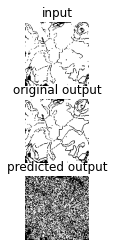

In [35]:
# visualize the prediction:

def visualize_prediction(pred_input, original_output, prediction):
    
    fig, axes = plt.subplots(3, 1, figsize=(20, 4))

    # Plot the input frame.
    ax = axes[0]
    ax.imshow(np.squeeze(img_from_input(pred_input,RESIZED_WIDTH,RESIZED_HEIGHT)), cmap="gray")
    ax.set_title(f"input")
    ax.axis("off")

    # Plot the original new frame.
    ax = axes[1]
    ax.imshow(np.squeeze(img_from_output(original_output,RESIZED_WIDTH,RESIZED_HEIGHT)), cmap="gray")
    ax.set_title(f"original output")
    ax.axis("off")

    # Plot the new frame.
    ax = axes[2]
    ax.imshow(np.squeeze(img_from_output(prediction[0],RESIZED_WIDTH,RESIZED_HEIGHT)), cmap="gray")
    ax.set_title(f"predicted output")
    ax.axis("off")

    # Display the figure.
    plt.show()
    
visualize_prediction(pred_input, pred_output, prediction)

